# Testing PyMC3
The code in this notebook attempts to replicate the code from the PyMC3 intro [paper](https://pymc-devs.github.io/pymc3/getting_started/).

## First example from the paper

In [14]:
# generate some data using numpy
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

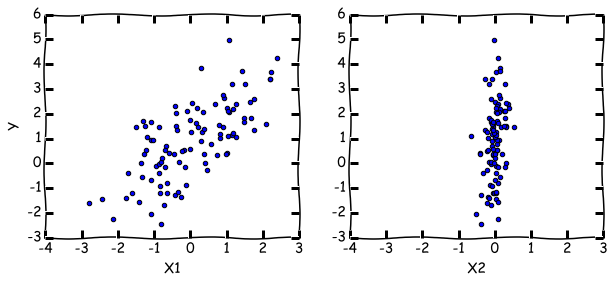

In [15]:
%matplotlib inline 

plt.xkcd()
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [16]:
# fit the data using pymc3
from pymc3 import Model, Normal, HalfNormal
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log to model.


In [23]:
# find the MAP estimates of all model parameters
from pymc3 import find_MAP
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

{'beta': array([ 0.948486  ,  2.60705513]), 'sigma_log': array(-0.032781468548420935), 'alpha': array(0.9065985664354854)}


In [24]:
# find the MAP estimates again, but change the optimization settings
# not really sure what this one is doing
from scipy import optimize
map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)
print(map_estimate)

{'beta': array([ 0.95140146,  2.61437458]), 'sigma_log': array(-0.03000977520318259), 'alpha': array(0.9090521898978398)}


In [25]:
# generate estimates of the full posterior
from pymc3 import NUTS, sample
with basic_model:
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    # draw 2000 posterior samples
    trace = sample(2000, start=start) 

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log
 [-----------------100%-----------------] 2000 of 2000 complete in 2.9 sec

In [58]:
# use slice sampling instead of NUTS
from pymc3 import Slice
with basic_model:
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    # instantiate sampler
    step = Slice(vars=[sigma]) 
    # draw 5000 posterior samples
    trace = sample(5000, step=step, start=start)

Assigned NUTS to alpha
Assigned NUTS to beta
 [-----------------100%-----------------] 5000 of 5000 complete in 9.6 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f4a1b00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ee86710>]], dtype=object)

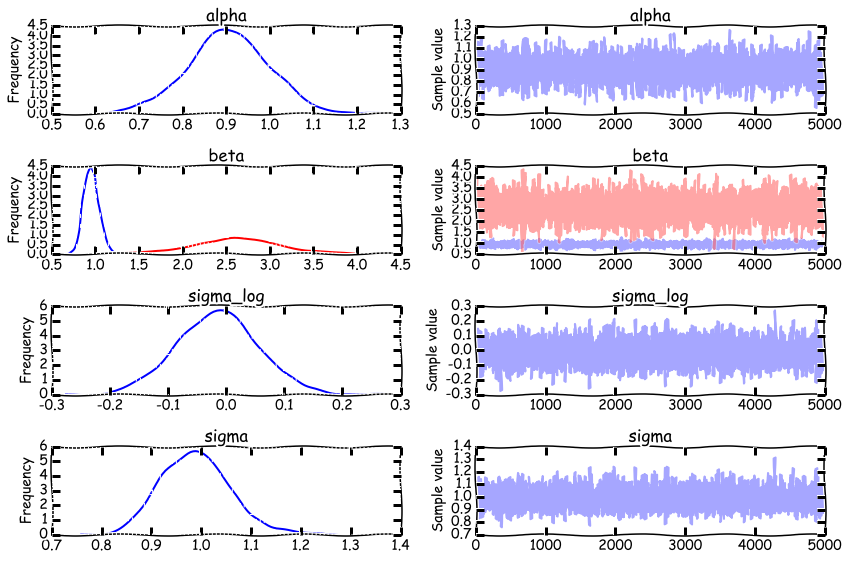

In [59]:
from pymc3 import traceplot
traceplot(trace)